# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

## Overview:

Imagine we are entering a drawing competition where the goal is to draw something amazing from scratch. Before the competition we train ourselves by looking at famous art, and observing the lines. To practice, we take a Monet, and then start to draw it ourselves, exclusively using arrows, trying to follow the lines. Then we compare our work to Monet's, with the goal that all our little arrows match his lines. Over time, the more we practice, the closer we can get out mental model to be like Monet's, and the better we will do in the art competition. This program is designed to do the process for us - to look at data, make some guesses of where the arrows should be, and create a model to use in the future.

To do this, we have one piece of paper we use as the answer key, and the other we write our guesses on. On our answer key, we have Monet's starry night. It's a beauty. So we go over to our guesses page and start drawing arrows wildly - at random almost! Then after a time we go back to our answer key and compare the two. We carefully add up the lengths of each arrow and compare. We erase some of the arrows on the guess paper and re-write them as we learn more. We group arrows together, starting with basic outlines and shapes, then filling in more complex features. Slowly, over time, we update our mental model for what each grouping of arrows should look like. Eventually we feel confident that, if given a fresh sheet of paper, by following our mental model of the groups of arrows, we could systematically make it look like the answer key. This mental knowledge we have gained is the machine's trained model. The arrows are vectors. Groups of arrows are matrices. In essence we are using the groups of arrows to detect patterns in the information.

This project has been quite interesting. This is a learning project, some code was provided by Udacity, some of the models are well known (ie LeNet, Dropout, etc.), and there a few functions from the forums. I have tried to be clear when there was obvious attribution. Enjoy! :)


---

# Step 1: Dataset exploration & pre-processing

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


In [1]:
# Load pickled data
import pickle

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(y_train)
print(y_train.shape)

print("Complete")

[ 0  0  0 ..., 42 42 42]
(39209,)
Complete


In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape is", image_shape)
print("Number of classes =", n_classes)
print(np.unique(y_train))
print("Complete")

Number of training examples = 39209
Number of testing examples = 12630
Image data shape is (32, 32, 3)
Number of classes = 43
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Complete


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

12
Complete


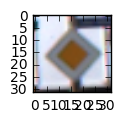

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(1, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])
print("Complete")

In [4]:
# TODO refactor into proper function

def to_gray_scale(img_data):
    return cv2.cvtColor(img_data.astype(np.float32), cv2.COLOR_RGB2GRAY)

import cv2

# credit to https://carnd-forums.udacity.com/questions/26216649/problem-when-converting-to-gray
X_train_gray = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

for feature in range(len(X_train)):
    #print(X_train[feature].dtype)
    X_train_gray[feature] = to_gray_scale(X_train[feature])
    
X_train = X_train_gray


15
Complete


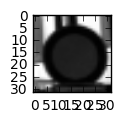

In [5]:
index = random.randint(1, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
print("Complete")

In [6]:
# After my own research shown here:
# https://carnd-forums.udacity.com/questions/36049206/how-to-scale-zoom-images-p2-traffic-sign
# Credit for this function to:
# https://carnd-forums.udacity.com/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image

import cv2

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    # updated to reflect gray pipeline
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

## Transformation testing

Original:


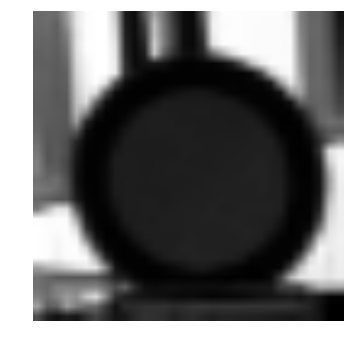

Generated images:


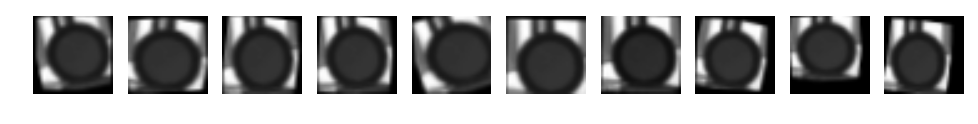

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

print("Original:")
plt.imshow(image, cmap="gray");
plt.axis('off');
plt.show()

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12,12))

print("Generated images:")
for i in range(10):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,30,4,4)

    plt.subplot(10,10,i+1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.show()

-----
## Image Generation

Generating additional features.
Bins [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]
39209
Current label name:  Speed limit (20km/h)
Current label id:  0
Number of features:  210
features_to_be_generated:  7290
Generating images for  Speed limit (20km/h)


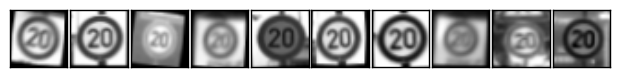

-----------------------------------------------------

Current label name:  Speed limit (30km/h)
Current label id:  1
Number of features:  2220
features_to_be_generated:  5280
Generating images for  Speed limit (30km/h)


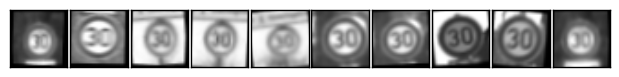

-----------------------------------------------------

Current label name:  Speed limit (50km/h)
Current label id:  2
Number of features:  2250
features_to_be_generated:  5250
Generating images for  Speed limit (50km/h)


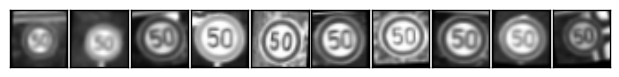

-----------------------------------------------------

Current label name:  Speed limit (60km/h)
Current label id:  3
Number of features:  1410
features_to_be_generated:  6090
Generating images for  Speed limit (60km/h)


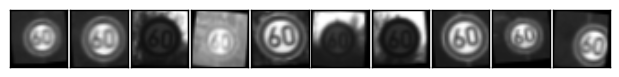

-----------------------------------------------------

Current label name:  Speed limit (70km/h)
Current label id:  4
Number of features:  1980
features_to_be_generated:  5520
Generating images for  Speed limit (70km/h)


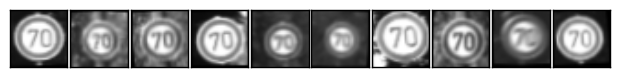

-----------------------------------------------------

Current label name:  Speed limit (80km/h)
Current label id:  5
Number of features:  1860
features_to_be_generated:  5640
Generating images for  Speed limit (80km/h)


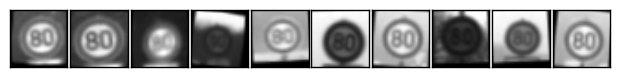

-----------------------------------------------------

Current label name:  End of speed limit (80km/h)
Current label id:  6
Number of features:  420
features_to_be_generated:  7080
Generating images for  End of speed limit (80km/h)


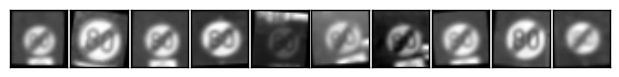

-----------------------------------------------------

Current label name:  Speed limit (100km/h)
Current label id:  7
Number of features:  1440
features_to_be_generated:  6060
Generating images for  Speed limit (100km/h)


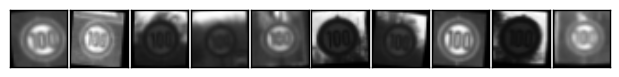

-----------------------------------------------------

Current label name:  Speed limit (120km/h)
Current label id:  8
Number of features:  1410
features_to_be_generated:  6090
Generating images for  Speed limit (120km/h)


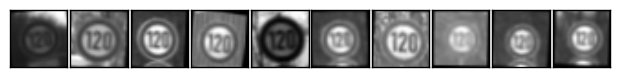

-----------------------------------------------------

Current label name:  No passing
Current label id:  9
Number of features:  1470
features_to_be_generated:  6030
Generating images for  No passing


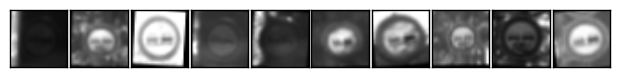

-----------------------------------------------------

Current label name:  No passing for vehicles over 3.5 metric tons
Current label id:  10
Number of features:  2010
features_to_be_generated:  5490
Generating images for  No passing for vehicles over 3.5 metric tons


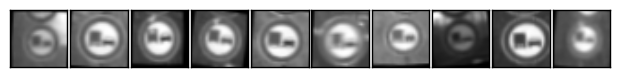

-----------------------------------------------------

Current label name:  Right-of-way at the next intersection
Current label id:  11
Number of features:  1320
features_to_be_generated:  6180
Generating images for  Right-of-way at the next intersection


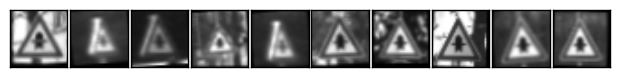

-----------------------------------------------------

Current label name:  Priority road
Current label id:  12
Number of features:  2100
features_to_be_generated:  5400
Generating images for  Priority road


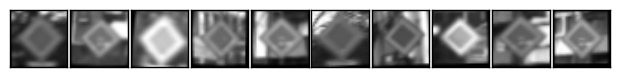

-----------------------------------------------------

Current label name:  Yield
Current label id:  13
Number of features:  2160
features_to_be_generated:  5340
Generating images for  Yield


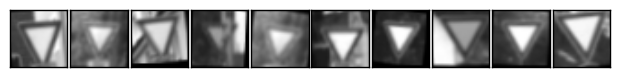

-----------------------------------------------------

Current label name:  Stop
Current label id:  14
Number of features:  780
features_to_be_generated:  6720
Generating images for  Stop


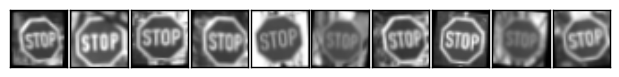

-----------------------------------------------------

Current label name:  No vehicles
Current label id:  15
Number of features:  630
features_to_be_generated:  6870
Generating images for  No vehicles


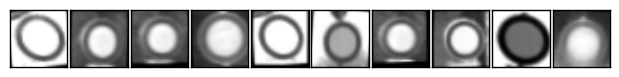

-----------------------------------------------------

Current label name:  Vehicles over 3.5 metric tons prohibited
Current label id:  16
Number of features:  420
features_to_be_generated:  7080
Generating images for  Vehicles over 3.5 metric tons prohibited


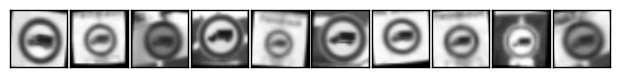

-----------------------------------------------------

Current label name:  No entry
Current label id:  17
Number of features:  1110
features_to_be_generated:  6390
Generating images for  No entry


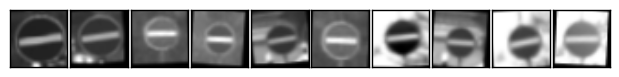

-----------------------------------------------------

Current label name:  General caution
Current label id:  18
Number of features:  1200
features_to_be_generated:  6300
Generating images for  General caution


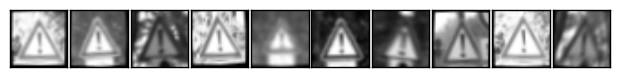

-----------------------------------------------------

Current label name:  Dangerous curve to the left
Current label id:  19
Number of features:  210
features_to_be_generated:  7290
Generating images for  Dangerous curve to the left


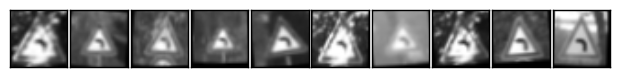

-----------------------------------------------------

Current label name:  Dangerous curve to the right
Current label id:  20
Number of features:  360
features_to_be_generated:  7140
Generating images for  Dangerous curve to the right


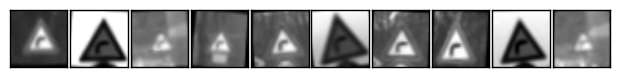

-----------------------------------------------------

Current label name:  Double curve
Current label id:  21
Number of features:  330
features_to_be_generated:  7170
Generating images for  Double curve


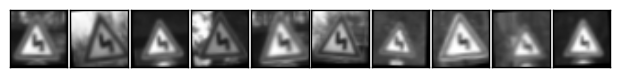

-----------------------------------------------------

Current label name:  Bumpy road
Current label id:  22
Number of features:  390
features_to_be_generated:  7110
Generating images for  Bumpy road


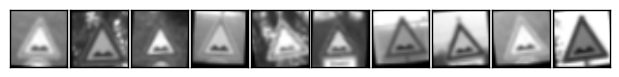

-----------------------------------------------------

Current label name:  Slippery road
Current label id:  23
Number of features:  510
features_to_be_generated:  6990
Generating images for  Slippery road


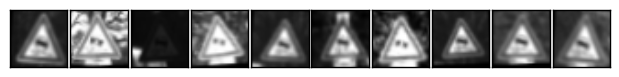

-----------------------------------------------------

Current label name:  Road narrows on the right
Current label id:  24
Number of features:  270
features_to_be_generated:  7230
Generating images for  Road narrows on the right


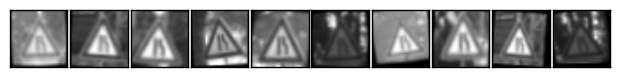

-----------------------------------------------------

Current label name:  Road work
Current label id:  25
Number of features:  1500
features_to_be_generated:  6000
Generating images for  Road work


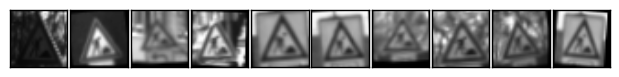

-----------------------------------------------------

Current label name:  Traffic signals
Current label id:  26
Number of features:  600
features_to_be_generated:  6900
Generating images for  Traffic signals


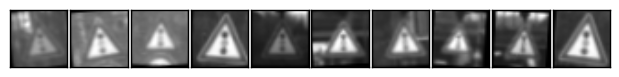

-----------------------------------------------------

Current label name:  Pedestrians
Current label id:  27
Number of features:  240
features_to_be_generated:  7260
Generating images for  Pedestrians


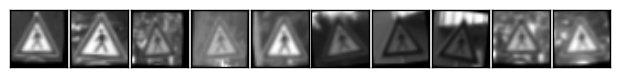

-----------------------------------------------------

Current label name:  Children crossing
Current label id:  28
Number of features:  540
features_to_be_generated:  6960
Generating images for  Children crossing


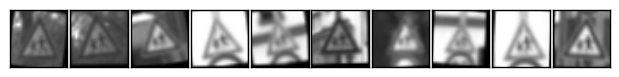

-----------------------------------------------------

Current label name:  Bicycles crossing
Current label id:  29
Number of features:  270
features_to_be_generated:  7230
Generating images for  Bicycles crossing


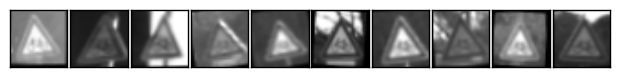

-----------------------------------------------------

Current label name:  Beware of ice/snow
Current label id:  30
Number of features:  450
features_to_be_generated:  7050
Generating images for  Beware of ice/snow


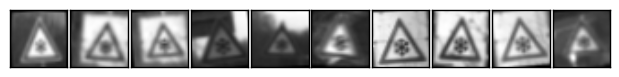

-----------------------------------------------------

Current label name:  Wild animals crossing
Current label id:  31
Number of features:  780
features_to_be_generated:  6720
Generating images for  Wild animals crossing


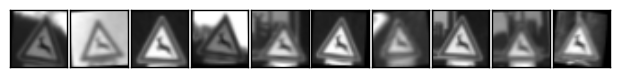

-----------------------------------------------------

Current label name:  End of all speed and passing limits
Current label id:  32
Number of features:  240
features_to_be_generated:  7260
Generating images for  End of all speed and passing limits


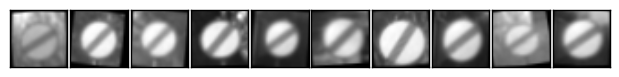

-----------------------------------------------------

Current label name:  Turn right ahead
Current label id:  33
Number of features:  689
features_to_be_generated:  6811
Generating images for  Turn right ahead


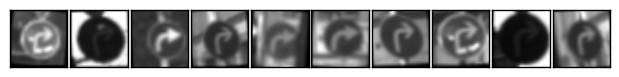

-----------------------------------------------------

Current label name:  Turn left ahead
Current label id:  34
Number of features:  420
features_to_be_generated:  7080
Generating images for  Turn left ahead


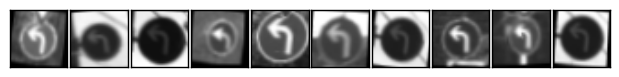

-----------------------------------------------------

Current label name:  Ahead only
Current label id:  35
Number of features:  1200
features_to_be_generated:  6300
Generating images for  Ahead only


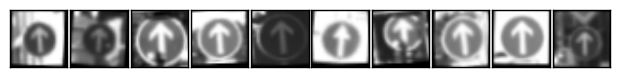

-----------------------------------------------------

Current label name:  Go straight or right
Current label id:  36
Number of features:  390
features_to_be_generated:  7110
Generating images for  Go straight or right


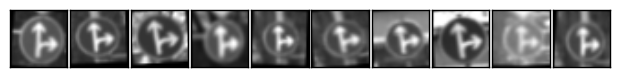

-----------------------------------------------------

Current label name:  Go straight or left
Current label id:  37
Number of features:  210
features_to_be_generated:  7290
Generating images for  Go straight or left


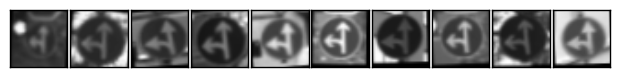

-----------------------------------------------------

Current label name:  Keep right
Current label id:  38
Number of features:  2070
features_to_be_generated:  5430
Generating images for  Keep right


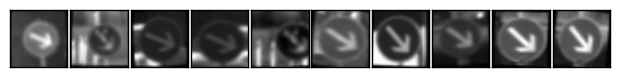

-----------------------------------------------------

Current label name:  Keep left
Current label id:  39
Number of features:  300
features_to_be_generated:  7200
Generating images for  Keep left


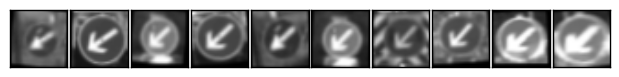

-----------------------------------------------------

Current label name:  Roundabout mandatory
Current label id:  40
Number of features:  360
features_to_be_generated:  7140
Generating images for  Roundabout mandatory


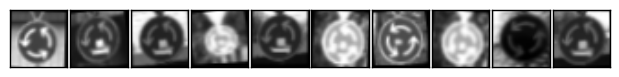

-----------------------------------------------------

Current label name:  End of no passing
Current label id:  41
Number of features:  240
features_to_be_generated:  7260
Generating images for  End of no passing


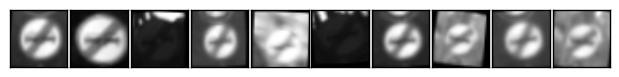

-----------------------------------------------------

Current label name:  End of no passing by vehicles over 3.5 metric tons
Current label id:  42
Number of features:  240
features_to_be_generated:  7260
Generating images for  End of no passing by vehicles over 3.5 metric tons


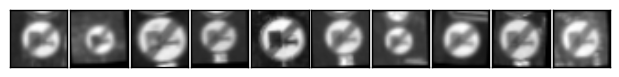

-----------------------------------------------------

Bins [7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500
 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500
 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500]
Complete


In [8]:
"""

This loop looks at each label in the data set and generates images up to the feature_count_goal.

"""

goal_number_of_features = 7500   # features per label
ang_range = 15   # Range of angles for rotation
shear_range = 2   # Range of values to apply affine transform to
trans_range = 2   # Range of values to apply translations over.

print("Generating additional features.")
print("Bins", np.bincount(y_train))

from pandas.io.parsers import read_csv
signnames = read_csv("signnames.csv").values[:, 1]
unique_labels = np.unique(y_train)

print(len(X_train))
    
for label_id in range(len(unique_labels)):
    
    unique_labels = np.unique(y_train)
    #Print update to feature tracking.
    print("Current label name: ", signnames[label_id])
    print("Current label id: ", label_id)
    
    #Print feature currently being generate    
    y_labels = np.where(y_train == label_id)
    
    number_of_features = len(X_train[y_labels])
    print("Number of features: ", number_of_features)
    feature_difference = goal_number_of_features - number_of_features
    
    # Set features to generate to 0 if less than 0
    if feature_difference > 0:
        features_to_be_generated = feature_difference
    else:
        features_to_be_generated = 0
    print("features_to_be_generated: ", features_to_be_generated)
    
    # Graceful handling if no features to be generated
    if features_to_be_generated > 0:
        
        print("Generating images for ", signnames[label_id])
        new_features = []
        new_labels = []
        
        # Start actually generated features while there are features to be generated
        while i <= features_to_be_generated:
            for feature in X_train[y_labels]:
                
                # Graceful stopping if > 1 passes through loop
                if features_to_be_generated == 0: 
                    break
                
                else:
                    # generate image
                    new_image = transform_image(feature,ang_range,shear_range,trans_range)
                    
                    new_features.append(new_image)
                    new_labels.append(label_id)
                    
                    features_to_be_generated = features_to_be_generated - 1
        i = i + 1

        # Append image to data
        # IMPORTANT axis=0 must be set or strange issues even though supposedly default is axis=0
        
        X_train = np.append(X_train, new_features, axis=0)
        y_train = np.append(y_train, new_labels, axis=0)
        
    else:
        print("Passing, no images to generate")
        
    # update y labels
    y_labels = np.where(y_train == label_id)
    x = np.array(y_labels)
    x_min = x[0, -200]
    x_max = x[0, -1]
    random_index = random.sample(range(x_min, x_max), 10)
    
    # graphing function concepts from http://navoshta.com/traffic-signs-classification/
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_index[i]], cmap="gray")
    plt.show()
    print("-----------------------------------------------------\n")


bins = np.bincount(y_train)
    
print("Bins", bins)
print("Complete")

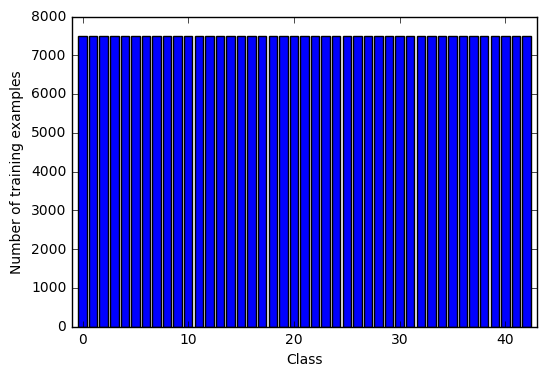

In [9]:
plt.bar( np.arange( 43 ), bins, align='center' )
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

In [10]:
   
# Normalize features
print('Scale features to be in 0 to 1')
X_train = (X_train / 255.).astype(np.float32)

inputs_per_class = np.bincount(y_train)
print(inputs_per_class)
n_train = len(X_train)

print("Number of training examples =", n_train)

# TODO store data in a pickle file

Scale features to be in 0 to 1
[7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500
 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500
 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500 7500]
Number of training examples = 322500


In [11]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
print("Complete")

Complete


## Validation set creation

In [12]:
# split into 80% for train and 20% for validation

seed = 54645
from sklearn.cross_validation import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=seed, stratify=y_train)
# Credit to someone in slack channel I think helped with sk.learn and to use stratify=y_train  80/20 split is common


In [13]:
n_train_new = len(X_train)
print("Number of training examples =", n_train_new)

n_validation = len(X_validation)
print("Number of validation examples =", n_validation)

print("Complete")


Number of training examples = 258000
Number of validation examples = 64500
Complete


### Question 1  and  Question 2

_Describe how you preprocessed the data. Why did you choose that technique?_

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer for 1 and 2:**

From reading LeCun's paper on traffic sign recongition he suggested generating additional data, ie by rotating, scaling, and shifting data. I then researched options to do so.

I had been used to using a cross validation set to test the network's performance prior to using the real test data. I researched ways to implmenet a validation set.

I used 5000 images per label, I split the data as described here:

    Original number of training examples = 39,209

    Number of training examples = 258,000
    Number of validation examples = 64,500

    Total generated images: 283,291

It seemed like a good idea to try and balance out the images. I feel further research is required on this however. For example, if a sign is less likely to appear in real life, perhaps it's ok if the network has a lower bias against it.

Based on suggestion from LeCun's paper and Udacity, I tried converting to grascale. Again, I'm not convinced this is actually better. I feel like there is an oppportunity for the network to learn colour - especially as many signs use colour to communicate meaning.

There is a feature normalization. Essentially instead of the workspace being in the 1-255 range, this brings it to the 0-1 range.

I'm also using a random seed and shuffule functions to help it start in a decent place for both training and validation set creation.

For generating the images I spent a lot of time on the loop functions. Essentially the key control is the target number of features per class. With this single control, the system builds images up to your desired amount, regardless of number of existing images in class. It perfectly balances it. But again, to above, I'm still not sure if that's the right path.

The code could use re-factoring. However, I think it's the start of a fairly flexible model. I could easily add in other functions to each image. I haven't benchmarked performance difference between this and batching, but intuitively I prefer the concept of running a while loop for this type of stuff then having to worry about batching. There are many things I would like to build into this, including checkpointing, dumping into a pickle file, tracking/estimating time to run, etc. 
.


----

# Step 2: Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [14]:
# settings

EPOCHS = 150
BATCH_SIZE = 256
LEARNING_RATE = 0.00005


In [15]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # gray scale fix
    # https://carnd-forums.udacity.com/questions/18449441/p2-valueerror-cannot-feed-value-of-shape-512-32-32-for-tensor-placeholder580-which-has-shape-32-32-1
    image = tf.reshape(x, [-1,32,32,1])

    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    convolutional_1_weights = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    convolutional_1_bias = tf.Variable(tf.zeros(6)) # set to 6 as output is 6
    convolutional_1 = tf.nn.conv2d(image, convolutional_1_weights, strides=[1,1,1,1], padding='VALID') + convolutional_1_bias
    
    # Activation.
    convolutional_1 = tf.nn.relu(convolutional_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # Stride of 2 reduces output by 2
    convolutional_1 = tf.nn.max_pool(convolutional_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    ## END Layer 1
    
    
    # Layer 2: Convolutional. Output = 10x10x16.
    convolutional_2_weights = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    convolutional_2_bias = tf.Variable(tf.zeros(16))
    # pass the first layer
    convolutional_2 = tf.nn.conv2d(convolutional_1, convolutional_2_weights, strides=[1,1,1,1], padding='VALID' ) + convolutional_2_bias
    
    # Activation.
    convolutional_2 = tf.nn.relu(convolutional_2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    convolutional_2 = tf.nn.max_pool(convolutional_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fully_connected_0 = flatten(convolutional_2)
    ### End Layer 2
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 160.
    fully_connected_1_weights = tf.Variable(tf.truncated_normal(shape=(400,160), mean=mu, stddev=sigma))
    fully_connected_1_bias = tf.Variable(tf.zeros(160))
    fully_connected_1 = tf.matmul(fully_connected_0, fully_connected_1_weights) + fully_connected_1_bias
    
    # Activation.
    fully_connected_1 = tf.nn.relu(fully_connected_1)
    
    # Layer 4: Fully Connected. Input = 160. Output = 84.
    # shape = (input, output)
    fully_connected_2_weights = tf.Variable(tf.truncated_normal(shape=(160,84), mean=mu, stddev=sigma))
    fully_connected_2_bias = tf.Variable(tf.zeros(84))
    fully_connected_2 = tf.matmul(fully_connected_1, fully_connected_2_weights) + fully_connected_2_bias
    
    # Activation.
    fully_connected_2 = tf.nn.relu(fully_connected_2)
    
    # drop out
    drop_out = tf.nn.dropout(fully_connected_2, keep_prob)
    
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fully_connected_3_weights = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fully_connected_3_bias = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop_out, fully_connected_3_weights) + fully_connected_3_bias
        
    return logits

print("Complete")

Complete


### Question 3

What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) 


**Answer:**

I primarily used the LetNet Architecture.

I also added drop_out as implemented by TensorFlow. I added dropout only to the last fully connected layer.


    The input to the model is the 32x32 images. 

As they are pre-processed to be gray scale there is only the single colour channel.

    The filter size in the first convolutional neural network is 5x5.

I used valid padding as it was the most clear to me.

    Max pooling strides are 2x2

    I'm using the built in tf.nn.conv2d to flatten from 4d to 2d.
    
 
I plan to experiment a much further with various architectures but felt I should start by getting a firm handle on what this one was working. I have commented more below on next steps.


In [16]:
### Train your model here.

x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# added this to fix bug CUDA_ERROR_ILLEGAL_ADDRESS / kernal crash
with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

print("Complete")

Complete


In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print("Complete")

Complete


## Training

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '.\lenet')
    print("Model saved")
    
print("Complete")

Training...

EPOCH 1 ...
Validation Accuracy = 0.346

EPOCH 2 ...
Validation Accuracy = 0.550

EPOCH 3 ...
Validation Accuracy = 0.644

EPOCH 4 ...
Validation Accuracy = 0.700

EPOCH 5 ...
Validation Accuracy = 0.739

EPOCH 6 ...
Validation Accuracy = 0.766

EPOCH 7 ...
Validation Accuracy = 0.791

EPOCH 8 ...
Validation Accuracy = 0.810

EPOCH 9 ...
Validation Accuracy = 0.824

EPOCH 10 ...
Validation Accuracy = 0.841

EPOCH 11 ...
Validation Accuracy = 0.852

EPOCH 12 ...
Validation Accuracy = 0.862

EPOCH 13 ...
Validation Accuracy = 0.870

EPOCH 14 ...
Validation Accuracy = 0.878

EPOCH 15 ...
Validation Accuracy = 0.886

EPOCH 16 ...
Validation Accuracy = 0.893

EPOCH 17 ...
Validation Accuracy = 0.897

EPOCH 18 ...
Validation Accuracy = 0.901

EPOCH 19 ...
Validation Accuracy = 0.905

EPOCH 20 ...
Validation Accuracy = 0.910

EPOCH 21 ...
Validation Accuracy = 0.912

EPOCH 22 ...
Validation Accuracy = 0.915

EPOCH 23 ...
Validation Accuracy = 0.918

EPOCH 24 ...
Validation Accura

## Evaluation

In [19]:
# pre processing
# TODO abstract this better...

X_test_gray = np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

for feature in range(len(X_test)):
    #print(X_train[feature].dtype)
    X_test_gray[feature] = to_gray_scale(X_test[feature])
    
X_test = X_test_gray

X_test = (X_test / 255.).astype(np.float32)

In [20]:
#Test data

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.935


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the AdamOptimizer from pervious lesson.  

I generally found anything above .0001 was too fast, in general it appears the higher the learning rate the greater the risk of over fitting.

    LEARNING_RATE = 0.00005

    Dropout is set to 50% as recommended by Mr. Hinton's paper. 

    One Hot is set at 43 as there are 43 classes.

    There are 150 epochs with a batch size of 256

I believe the model is overfitting the data given the ~5% delta in validation vs test. 

Lots of opportunity to improve here.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**


I started with LeNet, added dropout, added validation set, added binning comboed with jittery functions, and generating extra data. At each step I generally tested to at least 20 EPOCHs to see results, and mapped out results.

Beyond the apparently decent accuracy results, I don't know if it's suitable or not I simply don't know enough yet to comment effectively here.
 
The network has both convolutional and fully conected layers. The convolutional layers "scan" and help reduce duplciation of features. An example is of a red bike, a blue car, and a pink bunny. It would try to learn the concept of the colours seperately from the concepts of the items, so as to have 6 features instead of 9.

LeNet includes ReLu units as activations to create non-linearity in the model.  

To be clear this is the LeNet model, with dropout added, and various settings and filters tuned to the task at hand.

    Learn more about LeNet here http://yann.lecun.com/exdb/lenet/
    
Generally I followed an iterative process, adding features, than running the network to look at results.

---

# Step 3: Test on new input


## New input evaulation

In [21]:
from scipy.misc import imresize
new_label_sign_ids = read_csv("new_labels.csv").values[:, 0]
print(new_label_sign_ids)

imgs = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
new_input = []

for imgname in imgs:
    image = mpimg.imread('extra-images/' + imgname)
    image = imresize(image, (32,32))
    new_input.append(image)

[14 17 28 31 25]


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(1,)
(2,)
(3,)
(4,)
(5,)
[14, 17, 28, 31, 25]


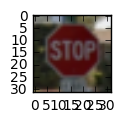

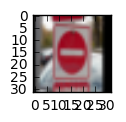

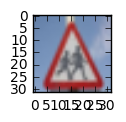

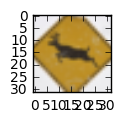

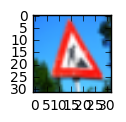

Number of training examples = 5
Number of labels = 5


In [22]:
# Combine images into pickle data format following help from forums

imagesTogether = []
new_labels = []

for image in new_input:
    image = cv2.resize(image, (32, 32))
    print(image.shape)
    
    imagesTogether.append(image) 
    #print(len(imagesTogether))
    
    imagesTogetherNP=np.asarray(imagesTogether)
    #print(imagesTogetherNP.shape)
    
for i in new_label_sign_ids:
    
    new_labels.append(i)
    #print(len(new_labels))
    
    new_labelsNP=np.asarray(new_labels)
    print(new_labelsNP.shape)

print(new_labels)

for image in imagesTogetherNP:
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    plt.show()

print("Number of training examples =", len(imagesTogetherNP))
print("Number of labels =", len(new_labels))


In [23]:
X_input_gray = np.zeros([imagesTogetherNP.shape[0], imagesTogetherNP.shape[1], imagesTogetherNP.shape[2]])

for feature in range(len(imagesTogetherNP)):
    #print(X_train[feature].dtype)
    X_input_gray[feature] = to_gray_scale(imagesTogetherNP[feature])
    
imagesTogetherNP = X_input_gray


In [24]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(imagesTogetherNP, new_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    

Test Accuracy = 0.600


### Question 6

Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?

**Answer:**

The stop sign is taken from google streetview near my house. It's low resolution to start with which may make it challenging.

The children walking and man working signs are at angles which may make them harder.

The no entry sign is a small part of overall image and is a different style slightly from training data.

The one that will likely be difficult is the animal crossing. It's a different shape, colour, and overall style from the training data. The only similar feature is the animal image in the centre. I suspect it will be quite difficult for the system to classify.



### Question 7

Is your model able to perform equally well on captured pictures when compared to testing on the dataset?

**Answer:**

My model scored 60% on the limited new input set. A previous run with a faster learning rate scored 80%. I believe it held up fairly well overall. I plan to continue testing on more images as I make the code more robost.


In [25]:

new_input_32 = np.float32(imagesTogetherNP)

#print(X_test.dtype)
#print(imagesTogetherNP.dtype)
#print(new_input_32.dtype)

predictSoftmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Model restored")
    
    softmaxProb  = sess.run(predictSoftmax, feed_dict={x: new_input_32, keep_prob: 1.0})
         
    top5 = sess.run(tf.nn.top_k(tf.constant(softmaxProb), k=5, sorted=True))
    
    # calculate certainty of prediction vs next best one
    difference = softmaxProb[0] - softmaxProb[1]
    
    print(difference)
    print(top5)


Model restored
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[14,  0,  1,  2,  3],
       [ 9,  0,  1,  2,  3],
       [28,  0,  1,  2,  3],
       [16,  0,  1,  2,  3],
       [25,  0,  1,  2,  3]]))


Actual class:   Stop 


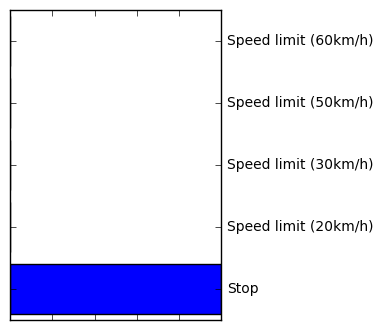

----------------------------------------------------------

Actual class:   No entry


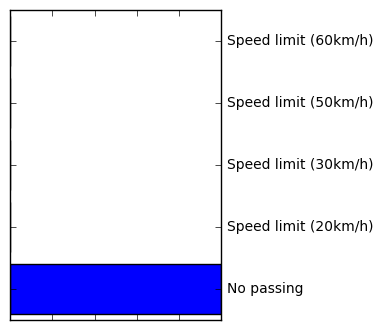

----------------------------------------------------------

Actual class:   Children cross


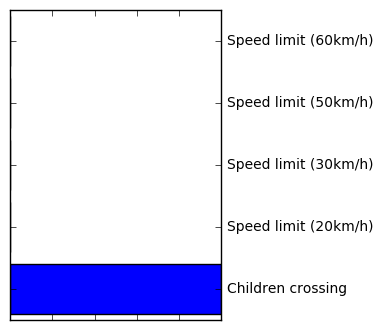

----------------------------------------------------------

Actual class:   Wild animals crossing


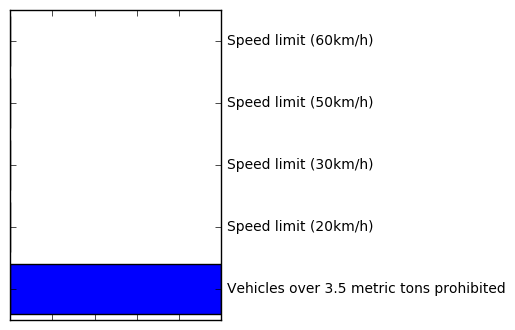

----------------------------------------------------------

Actual class:   Road work


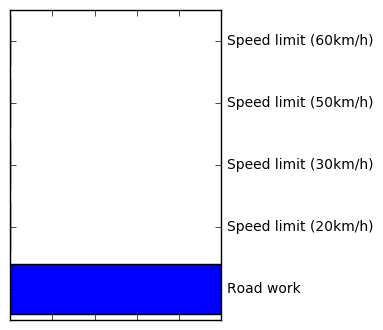

----------------------------------------------------------



In [26]:
new_label_sign_names = read_csv("new_labels.csv").values[:, 1]


# Credit https://github.com/navoshta/traffic-signs/blob/master/Traffic_Signs_Recognition.ipynb
def plot_image_statistics(predictions, index):
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, predictions[0][index], align='center')
    plt.yticks(np.arange(5)+.5, signnames[predictions[1][index].astype(int)])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    plt.show()
    
    
for i in range(5):
    print("Actual class: ", new_label_sign_names[i])
    plot_image_statistics(top5, i)
    print("----------------------------------------------------------\n")
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

My system seems to be indicating with near complete certainty that the category selected is correct. 

I believe this is further indication the model is overfitting. 

I plan to continue doing further research in this category.


-----
## Reflections

Overall this has been a very good learning experience.

My research direction on the applied side will be focusing on:

[] de convolutions and ways to better understand hidden layers

[] better understanding of plotting options data visualization

[] general refactoring to make the code here more robust, ie pre processing pipeline, new image inpute

[] deeper research into some of the functions I feel less comfortable with


I think the best moment in the project was when it correctly classified the stopsign I uploaded. That was the "WOW this works!" call.
